In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import glob
from os import listdir
from scipy.spatial.distance import cdist
from os.path import isfile, join
from matplotlib import pyplot as plt
from FaceDetectionModule import Face_Detector
from FaceGazeModule import GazeEstimator
from FaceLandmarksModule import Landmark_Extractor
from FaceEncoderModule import Face_Encoder

Imported Python modules.
Imported Python modules.
Imported Python modules.


# General Settings

In [2]:
device = "CPU"
cpu_extension_path = "cpu_extension_avx2.dll"
yaw_threshold = 15
detection_thresh = 0.7

# Load Face Detector Module

In [3]:
model_xml = r"Models\openvino\face-detection\FP32\face-detection-retail-0004.xml"
model_bin = r"Models\openvino\face-detection\FP32\face-detection-retail-0004.bin"

plugin = Landmark_Extractor.init_plugin(device,cpu_extension_path)

faceDetector = Face_Detector()

faceDetector.load_net(model_xml,model_bin,plugin)

INFO: All network layers are supported.
Input Shape: [1, 3, 300, 300]
Output Shape: [1, 1, 200, 7]


# Load Pose Estimator Module

In [4]:
model_xml = r"Models\openvino\gaze-estimation\FP32\head-pose-estimation-adas-0001.xml"
model_bin =r"Models\openvino\gaze-estimation\FP32\head-pose-estimation-adas-0001.bin"

gazeEstimator = GazeEstimator()

gazeEstimator.load_net(model_xml,model_bin,plugin)

INFO: All network layers are supported.
Input Shape: [1, 3, 60, 60]
Output Shape: [1, 1]*3 for (Y,P,R)


# Load Face Align Module

In [5]:
model_xml = r"Models\openvino\face-landmarks\FP32\facial-landmarks-35-adas-0002.xml"
model_bin = r"Models\openvino\face-landmarks\FP32\facial-landmarks-35-adas-0002.bin"

landmarkExtractor = Landmark_Extractor()

landmarkExtractor.load_net(model_xml,model_bin,plugin)

INFO: All network layers are supported.
Input Shape: [1, 3, 60, 60]
Output Shape: [1, 70]


# Load Face Encoder Module

In [6]:
model_xml = r"Models\openvino\face-identification\FP32\face-reidentification-retail-0095.xml"
model_bin = r"Models\openvino\face-identification\FP32\face-reidentification-retail-0095.bin"

faceEncoder = Face_Encoder()

faceEncoder.load_net(model_xml,model_bin,plugin)

INFO: All network layers are supported.
Input Shape: [1, 3, 128, 128]
Output Shape: [1, 256, 1, 1]


# Encode Training Images

In [7]:
def Train_Model(image_dir_path,yaw_threshold = 30,detection_thresh = 0.7,visualize = False,allowed_extensions = [".jpg",".jpeg",".png",".gif",".bmp"]):
    failed = []
    images = [f for f in listdir(image_dir_path) if isfile(join(image_dir_path, f)) and (f.lower()[-4:] in allowed_extensions)]
    img_count = len(images)
    count =0
    if len(images)>0:
        for imgname in images:
            print("============================================================")
            imgpath = image_dir_path + "/" + imgname
            img = cv2.imread(imgpath)
            try:
                count = count+1
                print("Training on Image: " + str(count) + " out of " + str(img_count))
                faces,_ = faceDetector.detectFaces(img,detection_thresh)
                if faces is None or len(faces) == 0:
                    print("Skipping image, no faces detected.")
                    failed.append(imgname)
                    continue
                elif len(faces)>1:
                    print("Skipping image, multiple faces detected.")
                    failed.append(imgname)
                    continue
                (x_min, y_min, x_max, y_max) = faces[0]
                img = img[y_min:y_max,x_min:x_max]  
                img = landmarkExtractor.prepare_face(img,visualize,False)
                y,_,_ = gazeEstimator.detectFaces(img)
                print("Yaw = " + str(y))
                if y>yaw_threshold or y< -yaw_threshold:
                    print("Skipping image, face Yaw exceeded provided threshold.")
                    failed.append(imgname)
                    continue
                #if visualize:
                 #   plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                  #  plt.show()
                face_encoding = faceEncoder.encode_face(img)
                np.save(imgpath[0:-4] ,face_encoding)
            except Exception as e:
                print(e)
                failed.append(imgname)
                continue
    return failed

In [72]:
def crop_with_margin(img,x_min,y_min,x_max,y_max,margin_x_rate = 0.125 , margin_y_rate = 0.125):
    margin_x = int((x_max-x_min) * margin_x_rate)
    margin_y = int((y_max-y_min) * margin_y_rate)
    img = img[max(y_min-margin_y,0):min(y_max+margin_y,img.shape[0]),max(x_min-margin_x-0,0):min(x_max+margin_x,img.shape[1])]
    return img

In [74]:
for img_path in glob.glob("C:\ProgramData\Anaconda3\Face_DB\*.*"):
    
    img = cv2.imread(img_path)
    result = faceDetector.detectFaces(img)
    print(result)
    if len(result[0])==0:
        continue
        
    (x_min,y_min,x_max,y_max) = result[0][0]

    cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(255,255,0),2)
    
    img = crop_with_margin(img,x_min,y_min,x_max,y_max)

    cv2.imshow("output",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

([(11, 9, 47, 61)], 1)
([(13, 11, 58, 79)], 1)
([], 0)
([(106, 110, 506, 667)], 1)
([(463, 12, 873, 672)], 1)
([(288, 55, 481, 328)], 1)
([(28, 30, 97, 117)], 1)
([(184, 117, 454, 509)], 1)
([(274, 49, 528, 422)], 1)
([(119, 112, 260, 308)], 1)
([(161, 279, 372, 567)], 1)
([(487, 68, 684, 395)], 1)
([(114, 244, 358, 571)], 1)
([(30, 128, 493, 748)], 1)
([(33, 52, 169, 237)], 1)
([(382, 61, 658, 472)], 1)
([(153, 29, 446, 454)], 1)
([(153, 204, 367, 522)], 1)


In [63]:
y_min-margin

NameError: name 'margin' is not defined

In [46]:
max(x_min-margin_x-0,0)

0

Training on Image: 1 out of 16


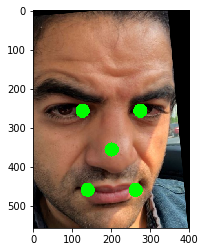

Yaw = 4.5000696
Training on Image: 2 out of 16


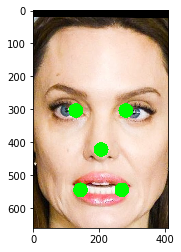

Yaw = -5.2790956
Training on Image: 3 out of 16


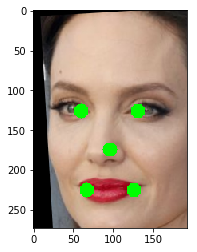

Yaw = -12.122407
Training on Image: 4 out of 16


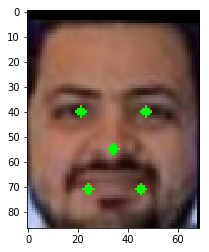

Yaw = 1.0444592
Training on Image: 5 out of 16


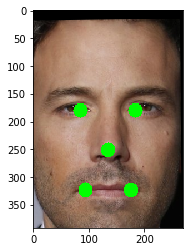

Yaw = 1.2356498
Training on Image: 6 out of 16


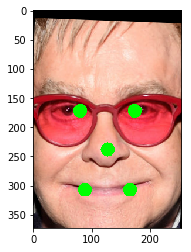

Yaw = -11.321614
Training on Image: 7 out of 16


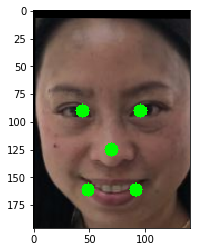

Yaw = -7.8640733
Training on Image: 8 out of 16


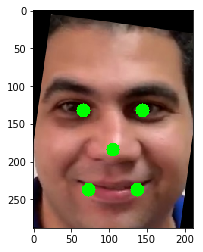

Yaw = 0.40653998
Training on Image: 9 out of 16


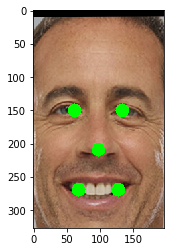

Yaw = -3.7971606
Training on Image: 10 out of 16


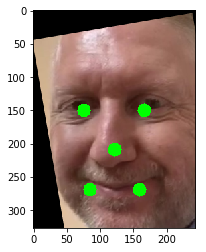

Yaw = -4.6357684
Training on Image: 11 out of 16


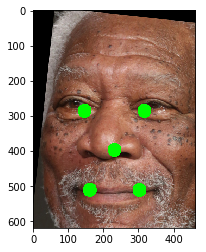

Yaw = -8.842365
Training on Image: 12 out of 16


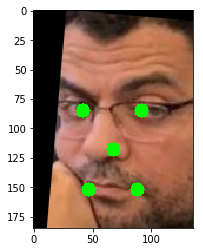

Yaw = -14.702032
Training on Image: 13 out of 16
Skipping image, no faces detected.
Training on Image: 14 out of 16


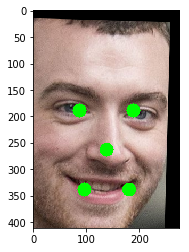

Yaw = 3.947587
Training on Image: 15 out of 16


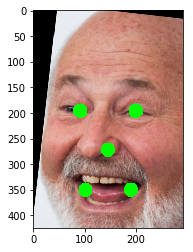

Yaw = -13.808068
Training on Image: 16 out of 16


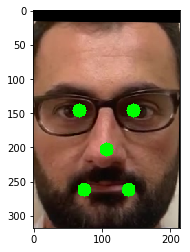

Yaw = -2.9205184


['nature_and_sea.jpg']

In [9]:
Train_Model(r"C:\Users\ADNEC- VW 3\Notebooks\Images",visualize=True,yaw_threshold=yaw_threshold)

# Generate Encoding For a Single Image

In [23]:
def FindMatchedFace(img,df,match_thresh = 0.4,visualize=False,yaw_threshold = 30,detection_thresh = 0.7):
    faces,_ = faceDetector.detectFaces(img,detection_thresh)
    if faces is None or len(faces) == 0:
        return -1,None #No faces detected
    detected = []
    encs = []
    coords = []
    for (x_min, y_min, x_max, y_max) in faces:
        crop = img[y_min:y_max,x_min:x_max]  
        crop = landmarkExtractor.prepare_face(crop,visualize,False)
        y,_,_ = gazeEstimator.detectFaces(img)
        #print(y)
        if y<yaw_threshold and y>-yaw_threshold:
            face_encoding = faceEncoder.encode_face(crop)
            encs.append(face_encoding)
            coords.append((x_min, y_min, x_max, y_max))
    if(len(encs) == 0):
        return -2,None #Faces detected but all of them unfit for comparisons
    dists = cdist(encs,df,"cosine")
    #print(dists)
    for i,dist in enumerate(dists):
        match_ix = np.argmin(dist)
        if dist[match_ix]<=match_thresh:
            detected.append((df.iloc[[match_ix]].index[0] , coords[i]))
        else:
            detected.append(("Unknown", coords[i]))
    if(len(detected)>0):
        return 1,detected
    else:
        return -3,None  #Faces detected but no valid matches found

# Load Dataset

In [11]:
def LoadImageEncoding(path):
    arr = np.load(path)
    return arr

def LoadAllImageEncondings(image_dir_path):
    encondings_files = [f for f in listdir(image_dir_path) if isfile(join(image_dir_path, f)) and (f.lower()[-4:] in [".npy"])]
    return {enc_file[0:-4] : LoadImageEncoding(image_dir_path + "/" + enc_file) for enc_file in encondings_files}

In [12]:
encs = LoadAllImageEncondings(r"C:\Users\ADNEC- VW 3\Notebooks\Images")
df = pd.DataFrame(encs).transpose()

In [15]:
for img_path in glob.glob(r"C:\Users\ADNEC- VW 3\Notebooks\Images\query\*.*"):
    img = cv2.imread(img_path)

    start = time.time()
    status,detected = FindMatchedFace(img,df,match_thresh=0.55,visualize=False,yaw_threshold = 20)
    end = time.time()

    print("Executed in {} milliseconds.".format(int((end-start)*1000)))
    #print(detected)

    if(status == 1):
        for (name,(x_min, y_min, x_max, y_max)) in detected:
            cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(255,255,0),2)
            cv2.putText(img,name,(x_min-5,y_min-10),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255))
        
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#plt.show()

    cv2.imshow("Output",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Executed in 56 milliseconds.
Executed in 93 milliseconds.
Executed in 59 milliseconds.
Executed in 93 milliseconds.
Executed in 129 milliseconds.
Executed in 129 milliseconds.
Executed in 94 milliseconds.
Executed in 55 milliseconds.
Executed in 128 milliseconds.
Executed in 56 milliseconds.
Executed in 55 milliseconds.
Executed in 56 milliseconds.
Executed in 93 milliseconds.
Executed in 672 milliseconds.
Executed in 57 milliseconds.
Executed in 94 milliseconds.
Executed in 56 milliseconds.
Executed in 57 milliseconds.
Executed in 59 milliseconds.
Executed in 63 milliseconds.


# Train Model

In [300]:

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()